## generate_data.py

In [1]:
import csv
import random
from datetime import datetime, timedelta
import json

# Generate data for 50 characters
NUM_ROWS = 1000

# Create the CSV file
OUTPUT_FILE = "troop_movements.csv"


def choose_a_side(home_world):
    """
    Randomly choose an empire or resistance side based on the likelihood 
    that someone from that world would join the rebel alliance.
    Args:
        home_world (dict): The home world data for the character.
    Returns:
        str: The empire or resistance side.
    """
    if home_world["rebel_likelihood"] > random.random():
        return "resistance"
    else:
        return "empire"


# Load home world data from JSON file
with open("home_worlds.json") as json_file:
    home_worlds = json.load(json_file)

# Generate data rows
data_rows = []
for i in range(1, NUM_ROWS + 1):
    # Generate random values for each column
    timestamp = datetime.now() - timedelta(seconds=i)
    unit_id = i
    unit_type = random.choice(
        ["stormtrooper", "tie_fighter", "at-st", "x-wing",
            "resistance_soldier", "at-at", "tie_silencer", "unknown"]
    )
    location_x = random.randint(1, 10)
    location_y = random.randint(1, 10)
    destination_x = random.randint(1, 10)
    destination_y = random.randint(1, 10)

    # Select a random home world from the available options
    home_world = random.choice(home_worlds)
    home_world_name = home_world["name"]
    empire_or_resistance = choose_a_side(home_world)

    # Create the data row
    data_row = [
        timestamp.strftime("%Y-%m-%d %H:%M:%S"),
        unit_id,
        unit_type,
        empire_or_resistance,
        location_x,
        location_y,
        destination_x,
        destination_y,
        home_world_name,
    ]

    # Add the data row to the list
    data_rows.append(data_row)

# Write the data to the CSV file
with open(OUTPUT_FILE, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(
        ["timestamp", "unit_id", "unit_type", "empire_or_resistance", "location_x", "location_y", "destination_x",
         "destination_y", "homeworld"]
    )
    writer.writerows(data_rows)

print("Data generation complete.")


Data generation complete.


### Display troop_movements.csv as DataFrame

In [2]:
import pandas as pd
df = pd.read_csv("troop_movements.csv")
print(df)

               timestamp  unit_id     unit_type empire_or_resistance  \
0    2024-02-07 11:42:58        1       unknown               empire   
1    2024-02-07 11:42:57        2         at-st               empire   
2    2024-02-07 11:42:56        3  stormtrooper           resistance   
3    2024-02-07 11:42:55        4   tie_fighter               empire   
4    2024-02-07 11:42:54        5       unknown               empire   
..                   ...      ...           ...                  ...   
995  2024-02-07 11:26:23      996  stormtrooper           resistance   
996  2024-02-07 11:26:22      997         at-st           resistance   
997  2024-02-07 11:26:21      998         at-st           resistance   
998  2024-02-07 11:26:20      999   tie_fighter               empire   
999  2024-02-07 11:26:19     1000  tie_silencer           resistance   

     location_x  location_y  destination_x  destination_y    homeworld  
0             7           5              4              9     

### Part 2: Build a prediction model

In [3]:
# Create grouped data showing counts of empire vs resistance.
er = df.groupby("empire_or_resistance").size().reset_index(name="count")
print(er.head())

  empire_or_resistance  count
0               empire    497
1           resistance    503


In [4]:
# Create grouped data showing counts of characters by homeworld
homeworld_counts = df.groupby("homeworld").size().reset_index(name="count")
print(homeworld_counts.head())


     homeworld  count
0     Alderaan     24
1  Aleen Minor     17
2   Bestine IV     28
3        Cerea     32
4     Champala     23


In [5]:
# Created grouped data showing counts of characters by unit_type
unit_type_counts = df.groupby("unit_type").size().reset_index(name="count")
print(unit_type_counts.head())


            unit_type  count
0               at-at    124
1               at-st    128
2  resistance_soldier    129
3        stormtrooper    138
4         tie_fighter    118


In [6]:
# Engineer a new feature called is_resistance with a True or False value based on empire_or_resiatance
df['is_resistance'] = df["empire_or_resistance"].map(lambda x: x == "resistance")
df.head()

,timestamp,unit_id,unit_type,empire_or_resistance,location_x,location_y,destination_x,destination_y,homeworld,is_resistance
0,2024-02-07 11:42:58,1,unknown,empire,7,5,4,9,Corellia,False
1,2024-02-07 11:42:57,2,at-st,empire,5,3,7,4,Stewjon,False
2,2024-02-07 11:42:56,3,stormtrooper,resistance,4,3,3,6,Iktotch,True
3,2024-02-07 11:42:55,4,tie_fighter,empire,7,9,5,1,Umbara,False
4,2024-02-07 11:42:54,5,unknown,empire,10,1,9,4,Aleen Minor,False


<Axes: xlabel='empire_or_resistance', ylabel='count'>

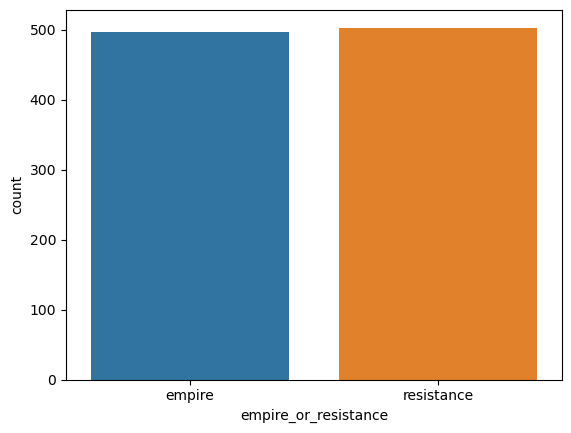

In [7]:
# Create a bar plot using Seaborn showing Empire vs Resistance distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x = 'empire_or_resistance',y='count',data = er)

In [8]:
# Create a prediction model using sklearn.tree.DecisionTreeClassifier that predicts if a character is joining either the Empire or the Resistance based on their homeworld and unit_type.
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

In [9]:
features = ["homeworld","unit_type"]
# Convert categorical features to numeric using pd.get_dummies. 
df1 = df.copy()
X_encoded = pd.get_dummies(df[features])
y_encoded = pd.get_dummies(df['empire_or_resistance'])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=1)

model = DecisionTreeClassifier()
model = model.fit(X_train,y_train)

y_pred = model.predict(X_test)
print(y_pred)

[[1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 0]
 [1 0]
 [1 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 0]
 [0 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [1 0]
 [1 0]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 0]
 [0 0]

                         Feature  Importance
0             homeworld_Alderaan    0.051439
1          homeworld_Aleen Minor    0.014861
2           homeworld_Bestine IV    0.003446
3                homeworld_Cerea    0.007044
4             homeworld_Champala    0.007062
5            homeworld_Chandrila    0.004659
6         homeworld_Concord Dawn    0.026701
7             homeworld_Corellia    0.042114
8              homeworld_Dagobah    0.031512
9             homeworld_Dathomir    0.002834
10               homeworld_Dorin    0.016736
11              homeworld_Eriadu    0.031999
12         homeworld_Glee Anselm    0.011008
13          homeworld_Haruun Kal    0.018403
14             homeworld_Iktotch    0.002348
15            homeworld_Iridonia    0.002134
16               homeworld_Kalee    0.021775
17            homeworld_Kashyyyk    0.003698
18           homeworld_Malastare    0.007317
19              homeworld_Mirial    0.010185
20            homeworld_Mon Cala    0.005459
21        

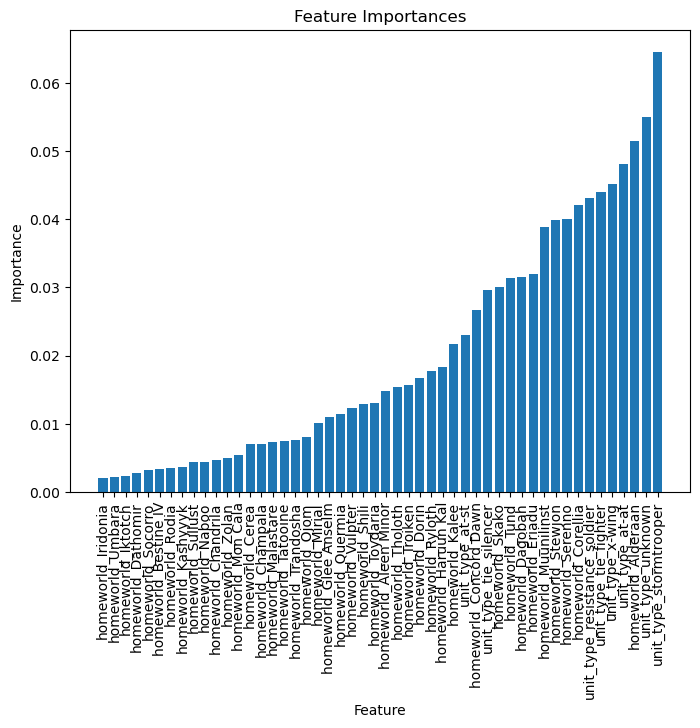

In [11]:
# Get feature importances
importances = model.feature_importances_

# Create a DataFrame to hold the feature importances
feature_importances = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': importances})
print(feature_importances)
feature_importances = feature_importances.sort_values('Importance', ascending=True)

# Create a bar plot that shows feature importance.
plt.figure(figsize=(8, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

In [12]:
# Save to model as a pickle file named trained_model.pkl
import pickle
filename = "trained_model.pkl"
with open(filename, 'wb') as file:
      pickle.dump(model, file)

### Part 3: Use the trained model with “real” data

Load data from troop_movements10m.csv (see Guided Project zip for file). This file contains 10 million records to be predicted. 
This data must be cleaned up a bit before it can be used:

⦁	Some unit_type records have a value of invalid_unit. Replace that with unknown.

⦁	Some location_x and location_Y values are missing. Use the ffill method to fill.

⦁	Save the clean data into a Parquet file named troop_movements10m.parquet.

⦁	You need to install pyarrow and fastparquet to support saving to a Parquet file.

pip install pyarrow

pip install fastparquet

Load the pickled model and load the data from the Parquet file into a data frame. Run the data through the model.


In [13]:
df_trained = pd.read_csv('troop_movements.csv')

In [14]:
%pip install pyarrow
%pip install fastparquet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [15]:
df_trained.unit_type.replace("invalid_unit","unknown")

0           unknown
1             at-st
2      stormtrooper
3       tie_fighter
4           unknown
           ...     
995    stormtrooper
996           at-st
997           at-st
998     tie_fighter
999    tie_silencer
Name: unit_type, Length: 1000, dtype: object

In [16]:
df_trained.location_x.ffill()
df_trained.location_y.ffill()


0      5
1      3
2      3
3      9
4      1
      ..
995    7
996    9
997    6
998    9
999    7
Name: location_y, Length: 1000, dtype: int64

In [17]:
pquet = df_trained.to_parquet("clean_troopers.parquet")

In [18]:
with open("trained_model.pkl",'rb') as f: 
    model2 = pickle.load(f)

parquet_db = pd.read_parquet('clean_troopers.parquet', engine = 'pyarrow')

In [19]:
features = ["homeworld","unit_type"]
# Convert categorical features to numeric using pd.get_dummies. 
X_encoded = pd.get_dummies(parquet_db[features])
y_encoded = pd.get_dummies(parquet_db['empire_or_resistance'])

print(X_encoded)
print(y_encoded)

     homeworld_Alderaan  homeworld_Aleen Minor  homeworld_Bestine IV  \
0                     0                      0                     0   
1                     0                      0                     0   
2                     0                      0                     0   
3                     0                      0                     0   
4                     0                      1                     0   
..                  ...                    ...                   ...   
995                   0                      0                     0   
996                   0                      0                     0   
997                   0                      0                     0   
998                   0                      0                     0   
999                   0                      0                     0   

     homeworld_Cerea  homeworld_Champala  homeworld_Chandrila  \
0                  0                   0                    0   
1    

In [20]:
ypred = model2.predict(X_encoded)


                         Feature  Importance
0             homeworld_Alderaan    0.051439
1          homeworld_Aleen Minor    0.014861
2           homeworld_Bestine IV    0.003446
3                homeworld_Cerea    0.007044
4             homeworld_Champala    0.007062
5            homeworld_Chandrila    0.004659
6         homeworld_Concord Dawn    0.026701
7             homeworld_Corellia    0.042114
8              homeworld_Dagobah    0.031512
9             homeworld_Dathomir    0.002834
10               homeworld_Dorin    0.016736
11              homeworld_Eriadu    0.031999
12         homeworld_Glee Anselm    0.011008
13          homeworld_Haruun Kal    0.018403
14             homeworld_Iktotch    0.002348
15            homeworld_Iridonia    0.002134
16               homeworld_Kalee    0.021775
17            homeworld_Kashyyyk    0.003698
18           homeworld_Malastare    0.007317
19              homeworld_Mirial    0.010185
20            homeworld_Mon Cala    0.005459
21        

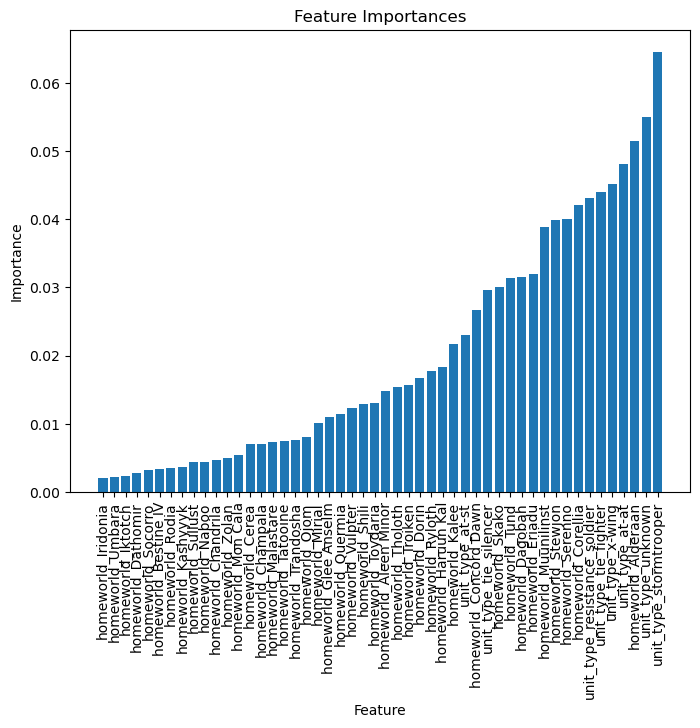

In [21]:
importances = model2.feature_importances_

# Create a DataFrame to hold the feature importances
feature_importances = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': importances})
print(feature_importances)
feature_importances = feature_importances.sort_values('Importance', ascending=True)

# Create a bar plot that shows feature importance.
plt.figure(figsize=(8, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()